### 

In [2]:
import time
import logging
from itertools import tee
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from river import datasets
from river import preprocessing
from river import base, metrics, stats, preprocessing, datasets
from river.drift import ADWIN, NoDrift


In [4]:
SEED = 42

### Synthetic Data Streams

In [5]:
#  create the dataset stream and copy it
dataset_generator = datasets.synth.FriedmanDrift(seed=SEED, 
                                                 position=(500,1000,10000)) # add some drift
# use 10k instances to see more drift effects
dataset = dataset_generator.take(10000) 
stream_standard, stream_smart = tee(dataset)

In [6]:
from river.forest import ARFRegressor

In [7]:
from river.forest import ARFRegressor
from models import SmartARFRegressor

N_MODELS_INITIAL = 10

arf_regressor = ARFRegressor(
        n_models=N_MODELS_INITIAL,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.001), # more sensitive drift for standard
        warning_detector=ADWIN(delta=0.01)
    )

smart_arf_regressor = SmartARFRegressor(
        n_models=N_MODELS_INITIAL,       # this is the "desired" initial, might be overridden by min_ensemble_size
        max_models=20,
        min_ensemble_size=5,             # <--- NEW: tell SmartARF to maintain at least 5
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.01),
        warning_detector=ADWIN(delta=0.1),
        regression_pruning_error_threshold=0.2,
        accuracy_drop_threshold=0.6,
        monitor_window=200,
        disable_weighted_vote=False,
        verbose_logging=True             # <--- For detailed logs
    )


Evaluating Standard ARF (Fixed Size Implementation)…
  Standard ARF - Step 10000, MAE: 2.0656, Num Models: 10, Drifts: 0
Standard ARF evaluation time: 21.85 seconds

Evaluating SmartARFRegressor…
[SmartARF Step 1] First learn_one. Effective n_models=10, max_models=20, min_ensemble_size=5
[SmartARF Step 1] Start learn_one. Current ensemble size: 10
[SmartARF Step 1] End learn_one. Final ensemble size: 10
[SmartARF Step 2] Start learn_one. Current ensemble size: 10
[SmartARF Step 2] End learn_one. Final ensemble size: 10
[SmartARF Step 3] Start learn_one. Current ensemble size: 10
[SmartARF Step 3] End learn_one. Final ensemble size: 10
[SmartARF Step 4] Start learn_one. Current ensemble size: 10
[SmartARF Step 4] End learn_one. Final ensemble size: 10
[SmartARF Step 5] Start learn_one. Current ensemble size: 10
[SmartARF Step 5] End learn_one. Final ensemble size: 10
[SmartARF Step 6] Start learn_one. Current ensemble size: 10
[SmartARF Step 6] End learn_one. Final ensemble size: 10
[Sm

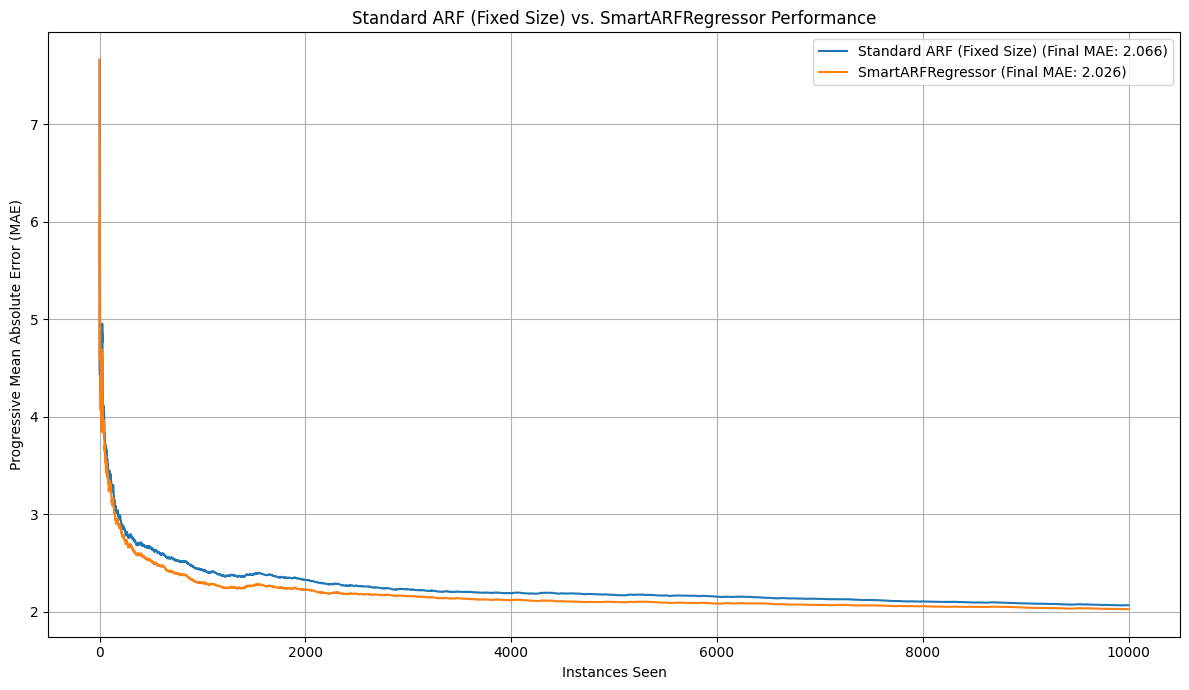


Plotting SmartARFRegressor Ensemble Size Over Time...


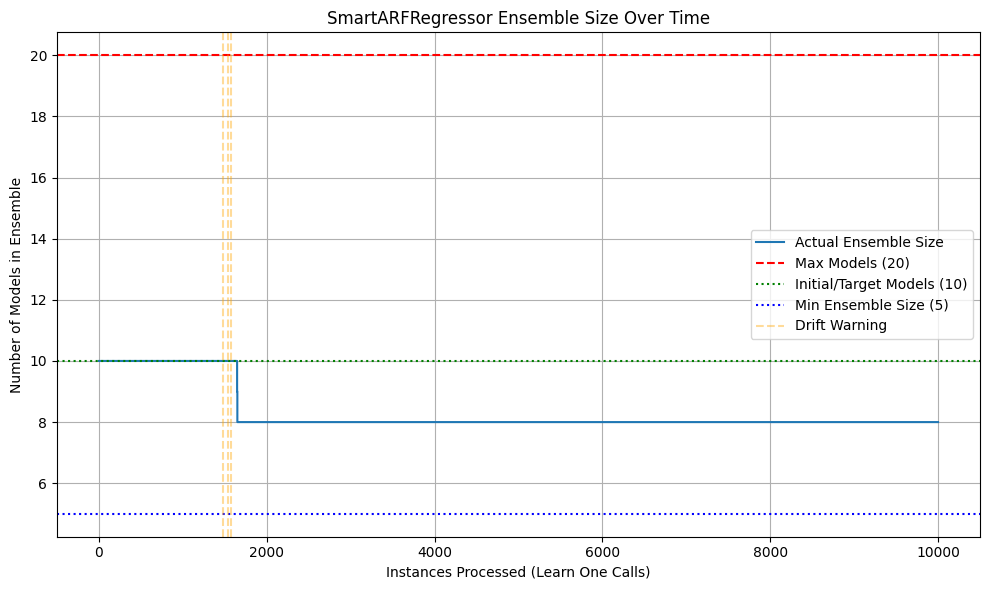


Standard ARF (Fixed Size) final number of models: 10


In [8]:
metric_eval_standard = metrics.MAE()
metric_eval_smart = metrics.MAE()
standard_mae_history = []
smart_mae_history = []

# --- Standard ARF ---
print("Evaluating Standard ARF (Fixed Size Implementation)…")
start_time_standard = time.time()
for i, (x, y) in enumerate(stream_standard):
    y_pred = arf_regressor.predict_one(x)
    if y_pred is not None:
        metric_eval_standard.update(y, y_pred)
        standard_mae_history.append(metric_eval_standard.get())
    else: # Handle cases where prediction might be None (e.g., uninitialized)
        standard_mae_history.append(standard_mae_history[-1] if standard_mae_history else 0.0)
    arf_regressor.learn_one(x, y)
    if (i + 1) % 10000 == 0: # Print less frequently
        num_models = len(arf_regressor)
        print(f"  Standard ARF - Step {i+1}, MAE: {metric_eval_standard.get():.4f}, "
              f"Num Models: {num_models}, Drifts: {arf_regressor.n_drifts_detected()}")
end_time_standard = time.time()
print(f"Standard ARF evaluation time: {end_time_standard - start_time_standard:.2f} seconds")

# --- SmartARFRegressor ---
print("\nEvaluating SmartARFRegressor…")
start_time_smart = time.time()
for i, (x, y) in enumerate(stream_smart):
    y_pred = smart_arf_regressor.predict_one(x)
    if y_pred is not None:
        metric_eval_smart.update(y, y_pred)
        smart_mae_history.append(metric_eval_smart.get())
    else:
        smart_mae_history.append(smart_mae_history[-1] if smart_mae_history else 0.0)
    smart_arf_regressor.learn_one(x, y)
    if (i + 1) % 10000 == 0: # Print less frequently
        num_models = len(smart_arf_regressor)
        print(f"  SmartARF - Step {i+1}, MAE: {metric_eval_smart.get():.4f}, "
              f"Num Models: {num_models}, Drifts: {smart_arf_regressor.n_drifts_detected()}")
end_time_smart = time.time()
print(f"SmartARFRegressor evaluation time: {end_time_smart - start_time_smart:.2f} seconds")

# 5. Final metrics
print("\n--- Final Results ---")
print(f"Standard ARF (Fixed Size) Final MAE: {metric_eval_standard.get():.4f}")
print(f"SmartARFRegressor Final MAE     : {metric_eval_smart.get():.4f}")

# 6. Plotting Performance
plt.figure(figsize=(12, 7))
plt.plot(standard_mae_history, label=f"Standard ARF (Fixed Size) (Final MAE: {metric_eval_standard.get():.3f})")
plt.plot(smart_mae_history, label=f"SmartARFRegressor (Final MAE: {metric_eval_smart.get():.3f})")
plt.xlabel("Instances Seen")
plt.ylabel("Progressive Mean Absolute Error (MAE)")
plt.title("Standard ARF (Fixed Size) vs. SmartARFRegressor Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Plotting Ensemble Size for SmartARFRegressor
if hasattr(smart_arf_regressor, 'plot_model_count'):
    print("\nPlotting SmartARFRegressor Ensemble Size Over Time...")
    smart_arf_regressor.plot_model_count(mark_warnings=True, mark_drifts=True)
else:
    print("SmartARFRegressor instance does not have a 'plot_model_count' method.")

num_standard_models_final = len(arf_regressor)
print(f"\nStandard ARF (Fixed Size) final number of models: {num_standard_models_final}")
if N_MODELS_INITIAL > 0 and num_standard_models_final != N_MODELS_INITIAL :
     # This warning is now more relevant as standard ARF is designed to be fixed-size.
     # However, during initialization or if n_models=0, it might differ.
     # For a fixed-size ARF, this should ideally always be N_MODELS_INITIAL after first learn_one if N_MODELS_INITIAL > 0.
     logging.warning(f"Standard ARF model count ({num_standard_models_final}) "
                    f"differs from initial n_models ({N_MODELS_INITIAL}). This should not happen for fixed-size ARF after initialization.")
elif N_MODELS_INITIAL == 0 and num_standard_models_final == 0:
     print("Standard ARF n_models was 0, so no models were initialized, as expected.")

# Real Data Streams

Datasets inspired by work:

*Sun, Yibin & Gomes, Heitor Murilo & Pfahringer, Bernhard & Bifet, Albert. (2025). Evaluation for Regression Analyses on Evolving Data Streams. 10.48550/arXiv.2502.07213.*

### Abalone dataset

In [9]:
import csv
from pathlib import Path

def load_abalone_stream():
    data_path = Path("datasets/abalone/abalone.data")
    with open(data_path, newline="") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            sex = row[0]
            features = {
                f"sex_{sex}": 1,
                "length": float(row[1]),
                "diameter": float(row[2]),
                "height": float(row[3]),
                "whole_weight": float(row[4]),
                "shucked_weight": float(row[5]),
                "viscera_weight": float(row[6]),
                "shell_weight": float(row[7]),
            }
            target = float(row[8])
            yield features, target


In [10]:
from itertools import tee

stream = load_abalone_stream()
stream_standard, stream_smart = tee(stream)

In [11]:
from river.forest import ARFRegressor
from models import SmartARFRegressor
from river.drift import ADWIN
from river import metrics

N_MODELS_INITIAL = 10

arf = ARFRegressor(
    n_models=N_MODELS_INITIAL,
    seed=42,
    lambda_value=6,
    grace_period=50,
    leaf_prediction="adaptive",
    metric=metrics.MAE(),
    drift_detector=ADWIN(delta=0.001),
    warning_detector=ADWIN(delta=0.01),
)

smart_arf = SmartARFRegressor(
    n_models=N_MODELS_INITIAL,
    max_models=20,
    min_ensemble_size=5,
    seed=42,
    lambda_value=6,
    grace_period=50,
    leaf_prediction="adaptive",
    metric=metrics.MAE(),
    drift_detector=ADWIN(delta=0.01),
    warning_detector=ADWIN(delta=0.1),
    verbose_logging=True,
)


Evaluating Standard ARF (Fixed Size Implementation)…
Standard ARF evaluation time: 309.17 seconds

Evaluating SmartARFRegressor…
[SmartARF Step 10001] Start learn_one. Current ensemble size: 8
[SmartARF Step 10001] AccDropCheck for warned model 6: Age 8529, CurrentAcc 0.055 (win 200), PastAcc 0.040, Thr 0.024
[SmartARF Step 10001] End learn_one. Final ensemble size: 8
[SmartARF Step 10002] Start learn_one. Current ensemble size: 8
[SmartARF Step 10002] AccDropCheck for warned model 6: Age 8530, CurrentAcc 0.055 (win 200), PastAcc 0.040, Thr 0.024
[SmartARF Step 10002] End learn_one. Final ensemble size: 8
[SmartARF Step 10003] Start learn_one. Current ensemble size: 8
[SmartARF Step 10003] AccDropCheck for warned model 6: Age 8531, CurrentAcc 0.055 (win 200), PastAcc 0.040, Thr 0.024
[SmartARF Step 10003] End learn_one. Final ensemble size: 8
[SmartARF Step 10004] Start learn_one. Current ensemble size: 8
[SmartARF Step 10004] AccDropCheck for warned model 6: Age 8532, CurrentAcc 0.055

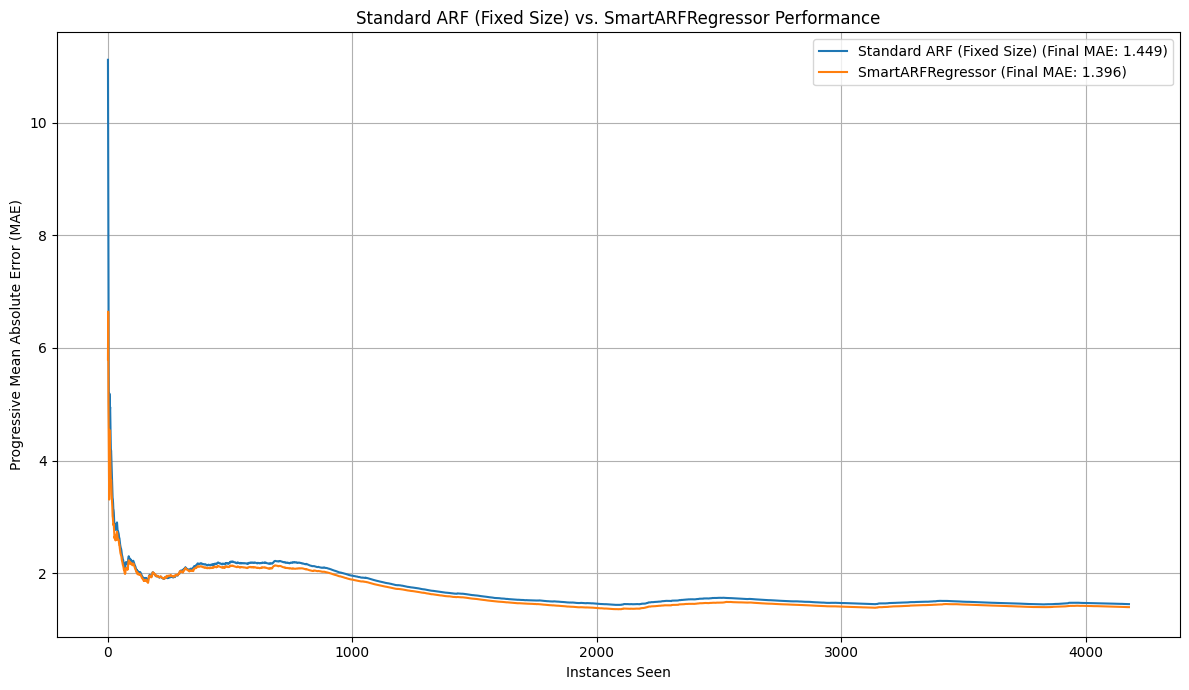


Plotting SmartARFRegressor Ensemble Size Over Time...


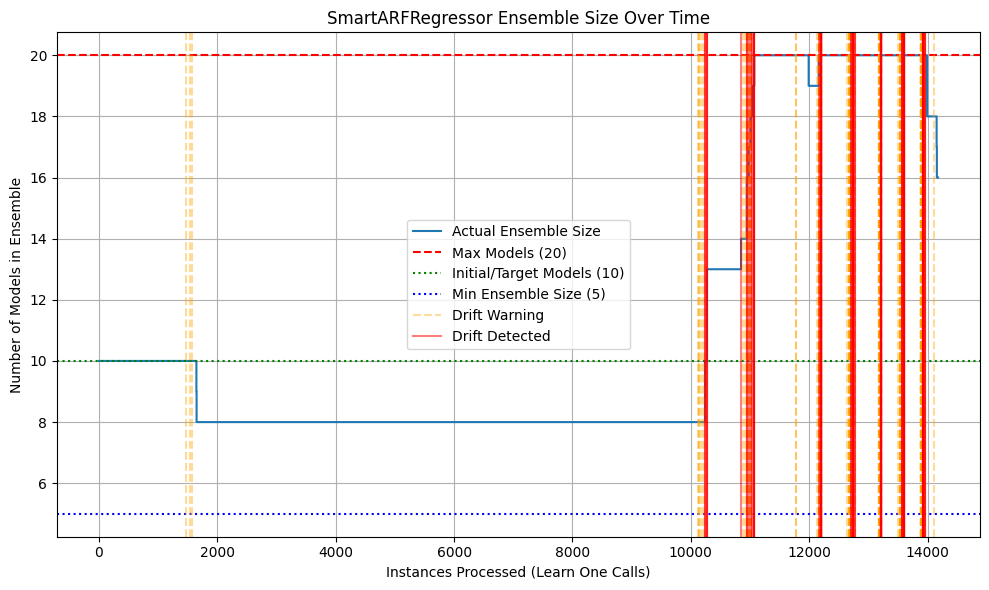


Standard ARF (Fixed Size) final number of models: 10


: 

In [12]:
metric_eval_standard = metrics.MAE()
metric_eval_smart = metrics.MAE()
standard_mae_history = []
smart_mae_history = []

# --- Standard ARF ---
print("Evaluating Standard ARF (Fixed Size Implementation)…")
start_time_standard = time.time()
for i, (x, y) in enumerate(stream_standard):
    y_pred = arf_regressor.predict_one(x)
    if y_pred is not None:
        metric_eval_standard.update(y, y_pred)
        standard_mae_history.append(metric_eval_standard.get())
    else: # Handle cases where prediction might be None (e.g., uninitialized)
        standard_mae_history.append(standard_mae_history[-1] if standard_mae_history else 0.0)
    arf_regressor.learn_one(x, y)
    if (i + 1) % 10000 == 0: # Print less frequently
        num_models = len(arf_regressor)
        print(f"  Standard ARF - Step {i+1}, MAE: {metric_eval_standard.get():.4f}, "
              f"Num Models: {num_models}, Drifts: {arf_regressor.n_drifts_detected()}")
end_time_standard = time.time()
print(f"Standard ARF evaluation time: {end_time_standard - start_time_standard:.2f} seconds")

# --- SmartARFRegressor ---
print("\nEvaluating SmartARFRegressor…")
start_time_smart = time.time()
for i, (x, y) in enumerate(stream_smart):
    y_pred = smart_arf_regressor.predict_one(x)
    if y_pred is not None:
        metric_eval_smart.update(y, y_pred)
        smart_mae_history.append(metric_eval_smart.get())
    else:
        smart_mae_history.append(smart_mae_history[-1] if smart_mae_history else 0.0)
    smart_arf_regressor.learn_one(x, y)
    if (i + 1) % 10000 == 0: # Print less frequently
        num_models = len(smart_arf_regressor)
        print(f"  SmartARF - Step {i+1}, MAE: {metric_eval_smart.get():.4f}, "
              f"Num Models: {num_models}, Drifts: {smart_arf_regressor.n_drifts_detected()}")
end_time_smart = time.time()
print(f"SmartARFRegressor evaluation time: {end_time_smart - start_time_smart:.2f} seconds")

# 5. Final metrics
print("\n--- Final Results ---")
print(f"Standard ARF (Fixed Size) Final MAE: {metric_eval_standard.get():.4f}")
print(f"SmartARFRegressor Final MAE     : {metric_eval_smart.get():.4f}")

# 6. Plotting Performance
plt.figure(figsize=(12, 7))
plt.plot(standard_mae_history, label=f"Standard ARF (Fixed Size) (Final MAE: {metric_eval_standard.get():.3f})")
plt.plot(smart_mae_history, label=f"SmartARFRegressor (Final MAE: {metric_eval_smart.get():.3f})")
plt.xlabel("Instances Seen")
plt.ylabel("Progressive Mean Absolute Error (MAE)")
plt.title("Standard ARF (Fixed Size) vs. SmartARFRegressor Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Plotting Ensemble Size for SmartARFRegressor
if hasattr(smart_arf_regressor, 'plot_model_count'):
    print("\nPlotting SmartARFRegressor Ensemble Size Over Time...")
    smart_arf_regressor.plot_model_count(mark_warnings=True, mark_drifts=True)
else:
    print("SmartARFRegressor instance does not have a 'plot_model_count' method.")

num_standard_models_final = len(arf_regressor)
print(f"\nStandard ARF (Fixed Size) final number of models: {num_standard_models_final}")
if N_MODELS_INITIAL > 0 and num_standard_models_final != N_MODELS_INITIAL :
     # This warning is now more relevant as standard ARF is designed to be fixed-size.
     # However, during initialization or if n_models=0, it might differ.
     # For a fixed-size ARF, this should ideally always be N_MODELS_INITIAL after first learn_one if N_MODELS_INITIAL > 0.
     logging.warning(f"Standard ARF model count ({num_standard_models_final}) "
                    f"differs from initial n_models ({N_MODELS_INITIAL}). This should not happen for fixed-size ARF after initialization.")
elif N_MODELS_INITIAL == 0 and num_standard_models_final == 0:
     print("Standard ARF n_models was 0, so no models were initialized, as expected.")

### Bike sharing dataset